# Head 1st / Head 2nd / Work 1st / Work 2nd

In [1]:
import pyreadstat
import os
import gc
import numpy as np
import copy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

.sav ===> import pyreadstat, pyreadstat.read_sav(file_path)

.sas7bdat  ====> pandas, pd.read_sas(file_path)

.dta  ===> pd.read_stata(file_path)

In [2]:
def call_df():
    path = 'C:/Users/hml76/Desktop/Jupyter/HRD_With_MJ/HCCPⅡ/'
    file_path = path+'SPSS/HCCPⅡ_2ndWave_Work_3rd.sav'

    dataframe, meta = pyreadstat.read_sav(file_path)
    columns_to_drop0 = ['W22ID2', 'W22ID3']
    dataframe = dataframe.drop(columns=columns_to_drop0)
    
    #y = df[y_name]
    #df.drop(columns=[y_name])
    gc.collect()
    return dataframe

In [3]:
def check_nan(input_dataframe):
    nan_values = input_dataframe.isna()
    nan_count_per_column = nan_values.sum()
    Nan_cols = []
    columns_with_nan = nan_count_per_column[nan_count_per_column > 0]  # Filter columns with NaN values
    print("Columns with NaN values and count of NaN values:")
    for column, count in columns_with_nan.items():
        print(f"Column '{column}' has {count} NaN value(s).")
        Nan_cols.append(column)    
        
    dataframe = input_dataframe.drop(columns=Nan_cols)
    return dataframe


def equal_distirubution(dataframe, y_lst, class_idx):
    class_counts = dataframe[y_lst[class_idx]].value_counts()
    print(class_counts)
    max_samples, min_samples = class_counts.max(), class_counts.min()
    
    balanced_df = pd.DataFrame()  # Initialize an empty DataFrame to store the balanced data
    
    for class_label, count in class_counts.items():
        if count == min_samples:      # If the class count is equal to the maximum number of samples, keep all samples
            balanced_df = pd.concat([balanced_df, dataframe[dataframe[y_lst[class_idx]] == class_label]])
        else:
            sampled_df = dataframe[dataframe[y_lst[class_idx]] == class_label].sample(min_samples, replace=True)  # Randomly sample the same number of samples from the class
            balanced_df = pd.concat([balanced_df, sampled_df])
    
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the rows 
    y_balanced = balanced_df[y_lst[class_idx]]
    print(y_balanced.value_counts())
    X_balanced = balanced_df.drop(columns=y_lst)
    
    return X_balanced, y_balanced

# ML models

In [4]:
def XGBoost(X_balanced, y_balanced):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = XGBClassifier(subsample=0.8, reg_lambda=0, reg_alpha=0.5, n_estimators=200,
                    min_child_weight=3, max_depth=7, learning_rate=0.1, gamma=0.1,
                    colsample_bytree=0.6)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

In [5]:
def LightGBM(X_balanced, y_balanced, num_boost_round = 300):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = LGBMClassifier(subsample=0.8, n_estimators=200, min_child_weight=1,
                     max_depth=5, learning_rate=0.1, colsample_bytree=0.8)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

In [6]:
def CatBoost(X_balanced, y_balanced, num_boost_round = 300):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = CatBoostClassifier(subsample=0.8, n_estimators=300, max_depth=5, learning_rate=0.3)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

In [7]:
def RF(X_balanced, y_balanced):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    #model = RandomForestClassifier(n_estimators=num_boost_round)
    model = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_depth=20, random_state=42)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

# Feature importance

In [8]:
def feature_imp1(input_model, X_train_, top_k):
    feature_importance = input_model.feature_importances_
    top_indices = np.argsort(feature_importance)[::-1][:top_k]
    top_indices = X.columns[top_indices]
    
    return top_indices

In [9]:
def feature_imp2(input_model, max_num_features):
    plot_importance(input_model, max_num_features)
    plt.show()

In [10]:
def class_one_to_five_TO_one_to_two(dataframe, y_lst, class_idx):
    dataframe_1 = dataframe[dataframe[y_lst[class_idx]] != 3]
    dataframe_1[y_lst[class_idx]] = dataframe_1[y_lst[class_idx]].map({1: 1, 2: 1, 4: 2, 5: 2})
    #dataframe_1 = dataframe_1.drop(columns=y_lst[class_idx])
    #print(dataframe_1[y_lst[class_idx]])
    return dataframe_1

In [11]:
def erase_col_for_importance(dataframe, erase_col_lst):
    dataframe = dataframe.drop(columns=erase_col_lst)
    
    return dataframe

In [12]:
scaler = MinMaxScaler()
df = call_df()
df = check_nan(df)
DF = copy.deepcopy(df)

Columns with NaN values and count of NaN values:


In [14]:
from sklearn.model_selection import RandomizedSearchCV

def RF_grid_search(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300], #400
        'max_depth': [10, 20, 30], #None
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    clf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    

def LGBM_grid_search(X_train, y_train):
    param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    }
    
    clf = LGBMClassifier()
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    
    

def Catboost_grid_search(X_train, y_train):
    param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    }
    
    clf = CatBoostClassifier(verbose=False)
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    

def XGBoost_grid_search(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0],
    }
    

    clf = XGBClassifier()
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

# Image - distribution sample

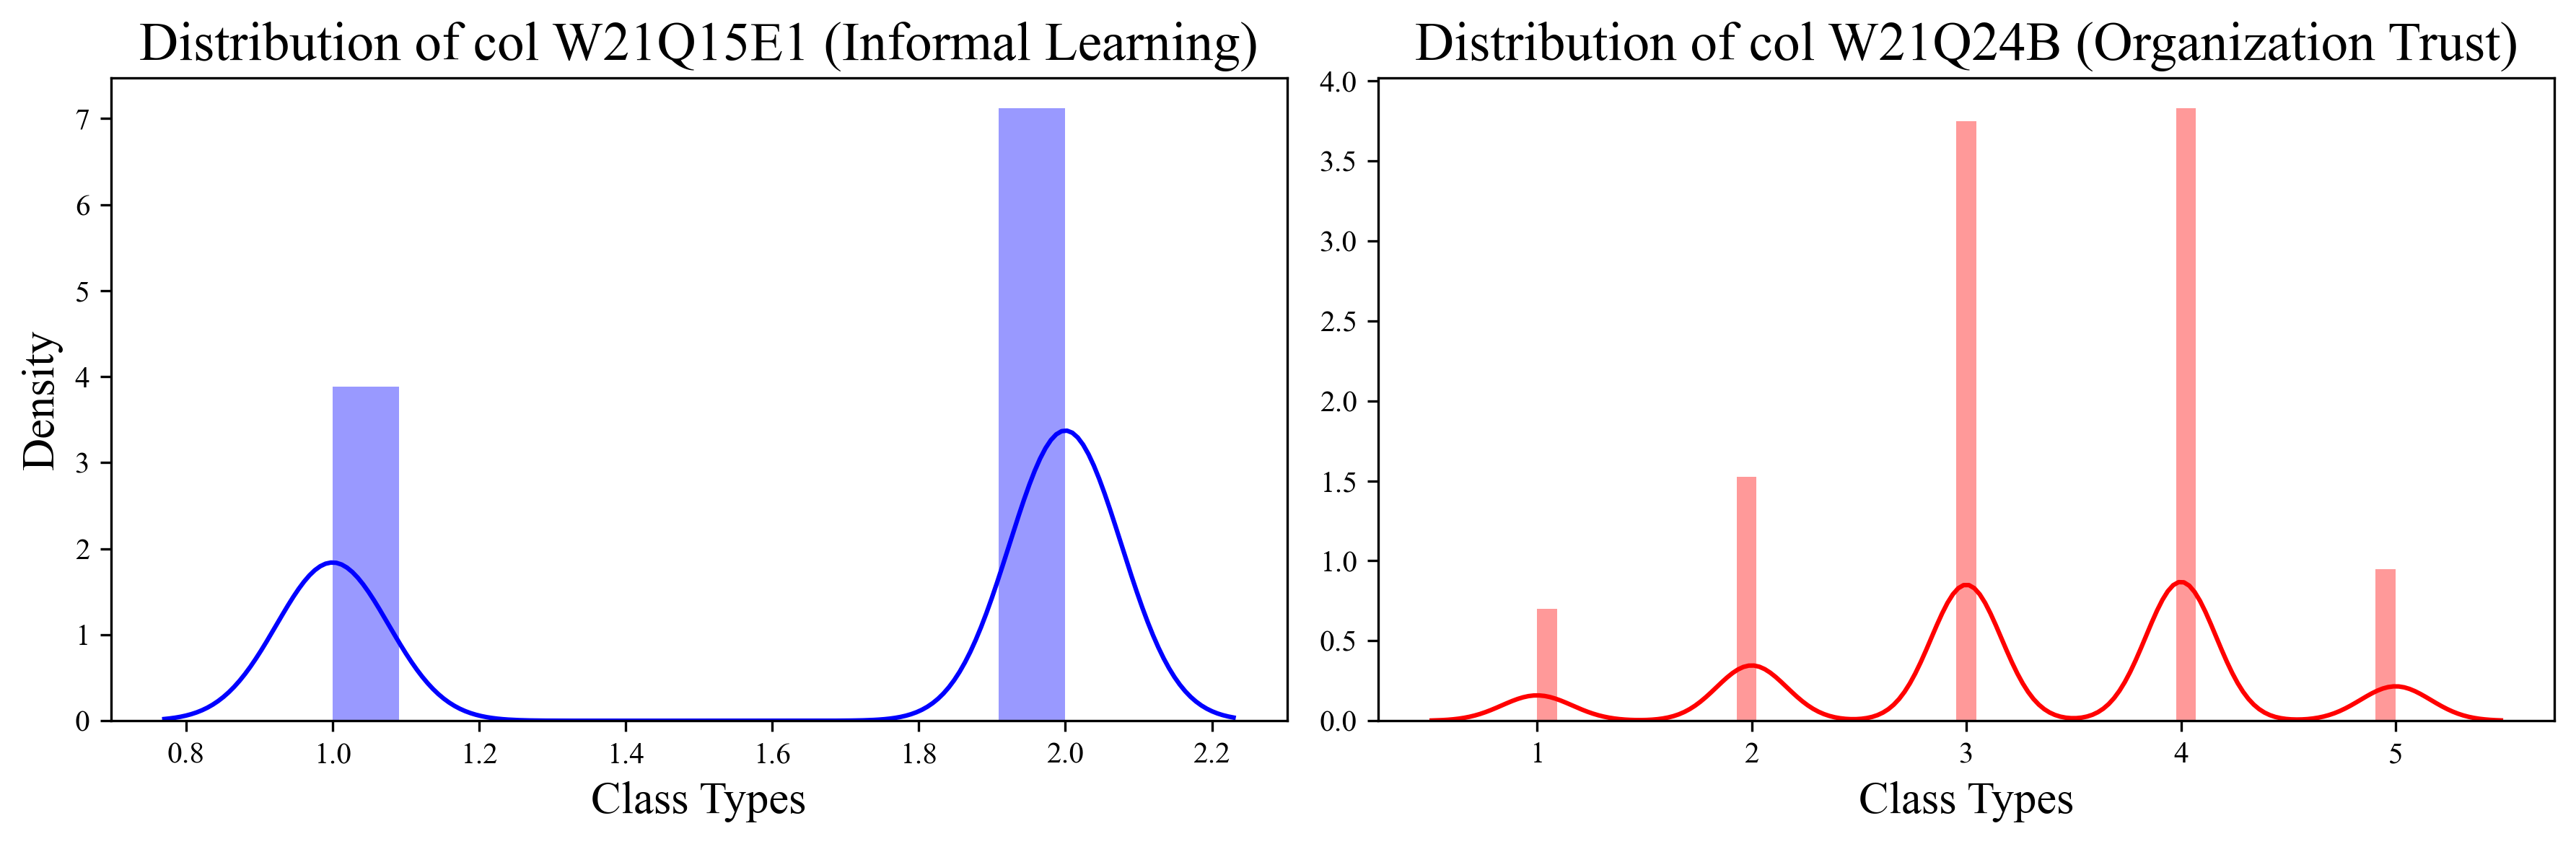

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

plt.rcParams['font.family'] = 'Times New Roman'
font = "Times New Roman"

sns.distplot(df['W22Q15E1'], ax=axes[0], color='blue')
axes[0].set_title("Distribution of col W21Q15E1 (Informal Learning)", fontsize=18)
axes[0].set_xlabel('Class Types', fontsize=15)
axes[0].set_ylabel("Density", fontsize=15)

sns.distplot(df['W22Q24B'], ax=axes[1], color='red')
axes[1].set_title("Distribution of col W21Q24B (Organization Trust)", fontsize=18)
axes[1].set_xlabel('Class Types', fontsize=15, fontname=font)
axes[1].set_ylabel("")


plt.tight_layout()
plt.show()

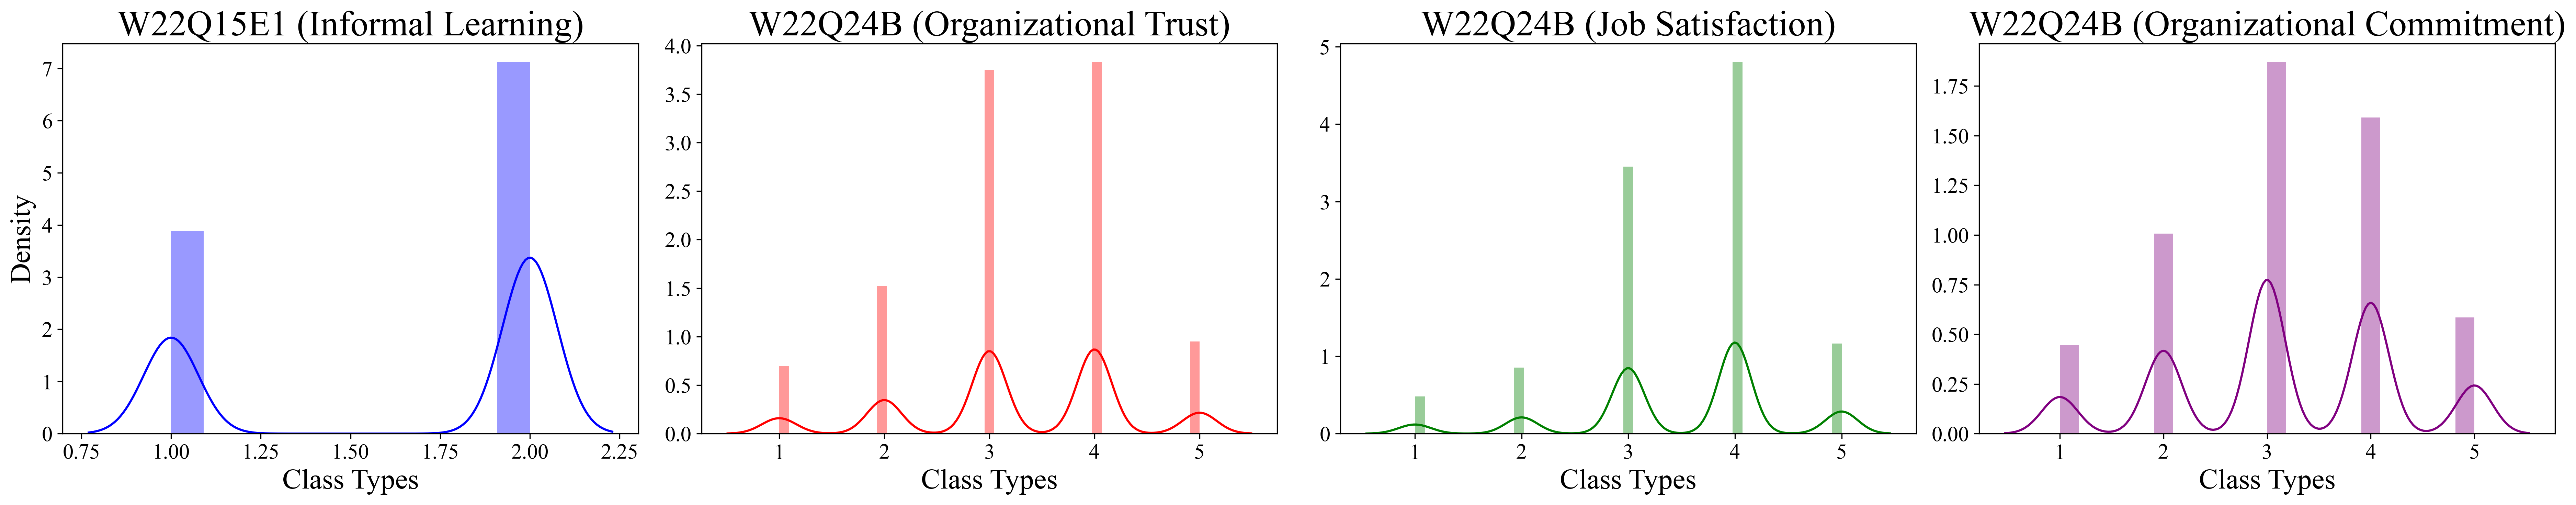

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5), dpi=300)

plt.rcParams['font.family'] = 'Times New Roman'
font = "Times New Roman"

axis_font, title_font = 20, 25

sns.distplot(df['W22Q15E1'], ax=axes[0], color='blue')
axes[0].set_title("W22Q15E1 (Informal Learning)", fontsize=title_font)
axes[0].set_xlabel('Class Types', fontsize=axis_font)
axes[0].set_ylabel("Density", fontsize=axis_font)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

sns.distplot(df['W22Q24B'], ax=axes[1], color='red')
axes[1].set_title("W22Q24B (Organizational Trust)", fontsize=title_font)
axes[1].set_xlabel('Class Types', fontsize=axis_font, fontname=font)
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

sns.distplot(df['W22Q26A'], ax=axes[2], color='green')
axes[2].set_title("W22Q24B (Job Satisfaction)", fontsize=title_font)
axes[2].set_xlabel('Class Types', fontsize=axis_font, fontname=font)
axes[2].set_ylabel("")
axes[2].tick_params(axis='x', labelsize=15)
axes[2].tick_params(axis='y', labelsize=15)

sns.distplot(df['W22Q27A'], ax=axes[3], color='purple')
axes[3].set_title("W22Q24B (Organizational Commitment)", fontsize=title_font)
axes[3].set_xlabel('Class Types', fontsize=axis_font, fontname=font)
axes[3].set_ylabel("")
axes[3].tick_params(axis='x', labelsize=15)
axes[3].tick_params(axis='y', labelsize=15)


plt.tight_layout()
plt.show()

In [18]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def XGBoost_learning_curve(X_balanced, y_balanced, title):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = XGBClassifier(subsample=0.8, reg_lambda=0, reg_alpha=0.5, n_estimators=200,
                          min_child_weight=3, max_depth=7, learning_rate=0.1, gamma=0.1,
                          colsample_bytree=0.6)

    eval_set = [(X_train, y_train), (X_test, y_test)]  # Use both training and test sets for evaluation
    eval_metric = ["error", "logloss"]  # Evaluation metrics to be monitored
    model.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=100, verbose=False)

    # Extracting the evaluation results
    eval_results = model.evals_result()

    # Plotting the learning curves
    num_epochs = len(eval_results['validation_0']['error'])  # Number of epochs
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(13, 3.5), dpi=150)
    plt.rcParams['font.family'] = 'Times New Roman'

    # Plot training and validation log loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, eval_results['validation_0']['logloss'], label='Train', marker='o', markersize=3)
    plt.plot(epochs, eval_results['validation_1']['logloss'], label='Test', marker='o', markersize=3)
    plt.xlabel('Number of Epochs', fontsize=13)
    plt.ylabel('Log Loss', fontsize=13)
    plt.title('{}'.format(title), fontsize=15)
    plt.legend(fontsize=12)
    
    #plt.tight_layout()
    plt.grid(True, linestyle='dotted')
    plt.show()

    return model, X_train, X_test, y_test

In [19]:
from sklearn.inspection import permutation_importance
def permutational_importance_(model, x_test_, y_test_, Xs):
    result = permutation_importance(model, x_test_, y_test_, n_repeats=10, random_state=42)

    feature_names = Xs.columns

    sorted_idx = result.importances_mean.argsort()

    #plt.figure(figsize=(10, 6))
    #plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
    #plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    #plt.xlabel('Permutation Importance')
    #plt.title('Permutation Importances')
    #plt.show()
    
    print(feature_names[sorted_idx][-10:])
    
    return feature_names[sorted_idx][-10:]

# 1. 비공식학습 참여여부

(1)동료에 의한 코칭 및 멘토링_비공식적 학습 방법 참여 여부

(2)상사에 의한 코칭 및 멘토링_비공식적 학습 방법 참여 여부

(3)직원들 개개인 간의 지식 및 노하우 공유_비공식적 학습 방법 참여 여부

(4)사내 플랫폼을 통한 지식 공유_비공식적 학습 방법 참여 여부

(5)직무순환을 통한 학습_비공식적 학습 방법 참여 여부

# Loss graph


 W22Q15A1 

W22Q15A1
1.0    5160
2.0    4352
Name: count, dtype: int64
W22Q15A1
1.0    4352
2.0    4352
Name: count, dtype: int64


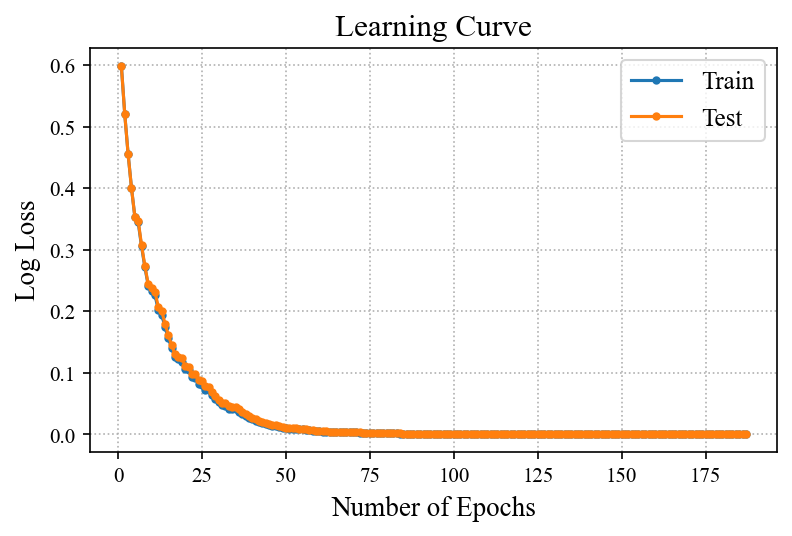


 W22Q15B1 

W22Q15B1
1.0    5617
2.0    3895
Name: count, dtype: int64
W22Q15B1
1.0    3895
2.0    3895
Name: count, dtype: int64


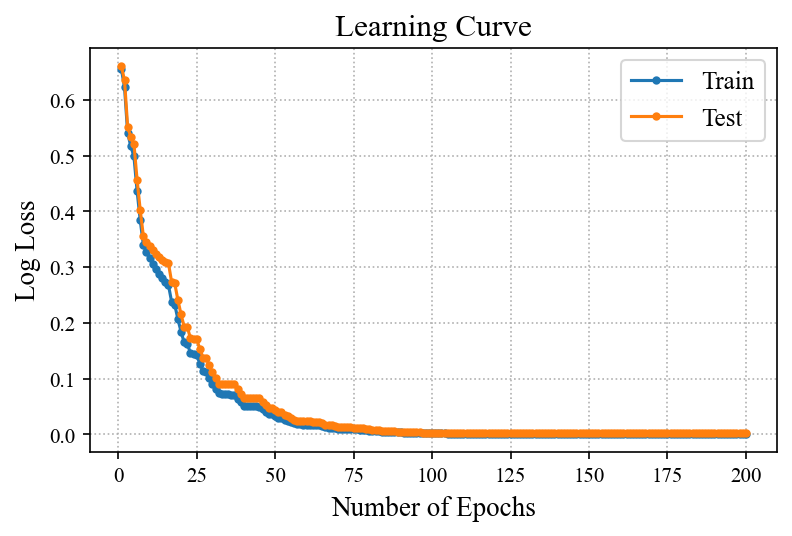


 W22Q15C1 

W22Q15C1
1.0    5954
2.0    3558
Name: count, dtype: int64
W22Q15C1
2.0    3558
1.0    3558
Name: count, dtype: int64


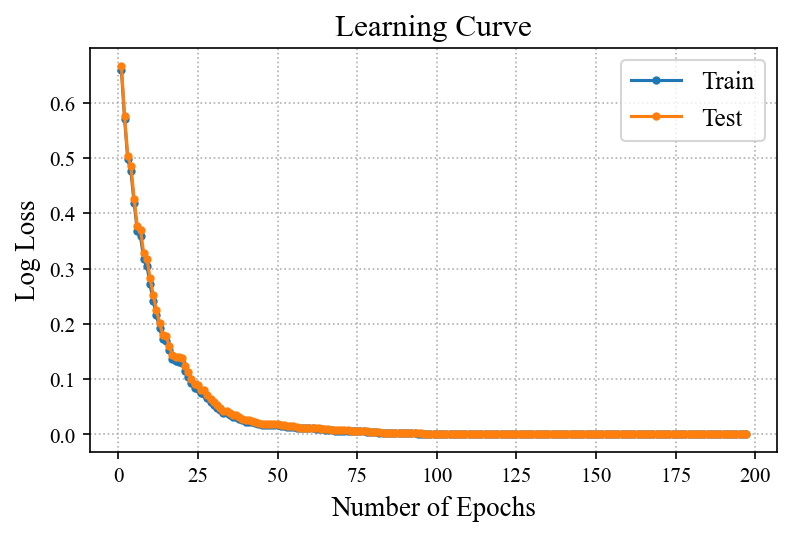


 W22Q15D1 

W22Q15D1
2.0    5451
1.0    4061
Name: count, dtype: int64
W22Q15D1
1.0    4061
2.0    4061
Name: count, dtype: int64


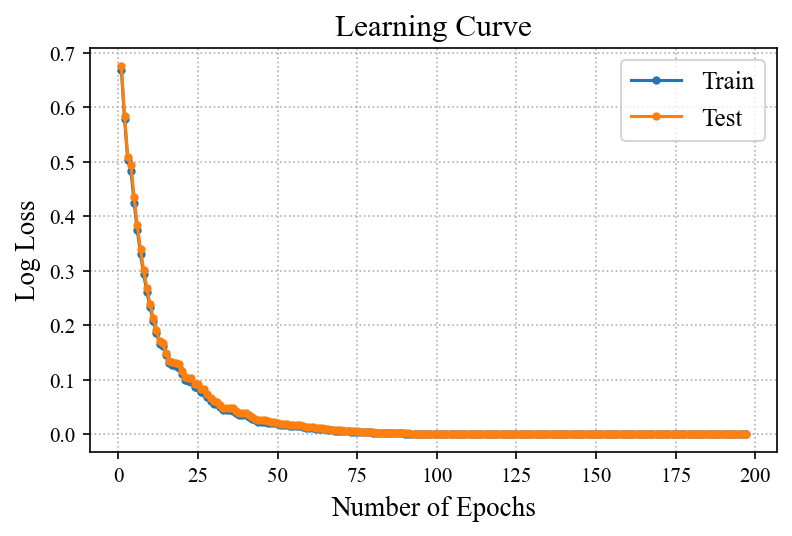


 W22Q15E1 

W22Q15E1
2.0    6155
1.0    3357
Name: count, dtype: int64
W22Q15E1
2.0    3357
1.0    3357
Name: count, dtype: int64


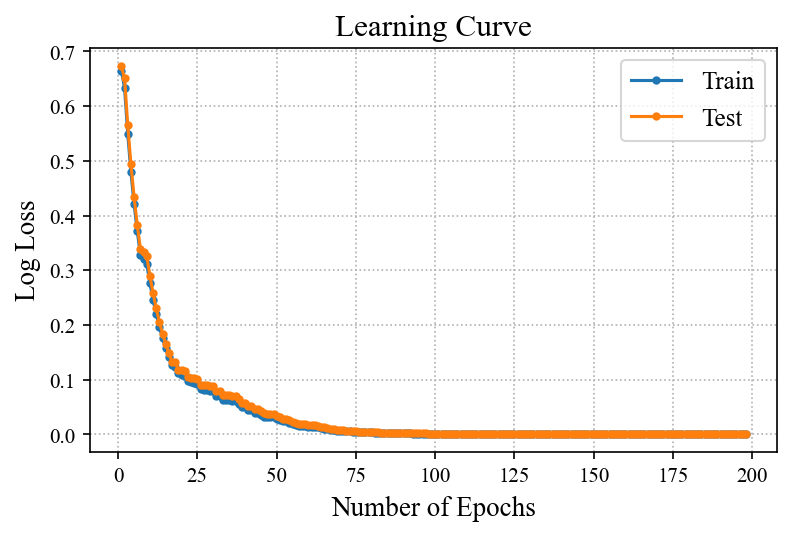

In [22]:
#binary class
Y = ['W22Q15A1', 'W22Q15B1', 'W22Q15C1', 'W22Q15D1', 'W22Q15E1'] #1. 비공식학습 참여여부  => 성능 나쁨; 거의 65% 
#Y2 = ['W21Q15A2', 'W21Q15B2', 'W21Q15C2', 'W21Q15D2', 'W21Q15E2'] # 비공식학습 학습성과 

for i in range(len(Y)):
#for i in range(1):
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X, y = equal_distirubution(df, Y, i)
    y=y-1
    
    #X = erase_col_for_importance(X, list2)
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Learning Curve')

# Learnings

In [33]:
y = y+1

In [34]:
#binary class
Y = ['W22Q15A1', 'W22Q15B1', 'W22Q15C1', 'W22Q15D1', 'W22Q15E1'] #1. 비공식학습 참여여부  => 성능 나쁨; 거의 65% 
#Y2 = ['W21Q15A2', 'W21Q15B2', 'W21Q15C2', 'W21Q15D2', 'W21Q15E2'] # 비공식학습 학습성과 

for i in range(len(Y)):
#for i in range(1):
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    #X, y = equal_distirubution(df, Y, i)
    #y=y-1
    
    #X = erase_col_for_importance(X, list2)
    model, x_tr, _, _ = XGBoost(X, y)
    model, x_tr, _, _ = LightGBM(X, y)
    model, x_tr, _, _ = CatBoost(X, y)
    model, x_tr, _, _ = RF(X, y)
    feature_imp1(model, x_tr, top_k=10)


 W22Q15A1 

	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0

 W22Q15B1 

	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0

 W22Q15C1 

	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0

 W22Q15D1 

	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0

 W22Q15E1 

	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0
	Accuracy ========>  1.0


# 3. 자기주도학습 참여여부

(1)학원 수강료 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

(2)국내 대학 등록금 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

(3)국내 대학원 등록금 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

(4)해외 대학원 학위과정 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

In [35]:
#Binary Class
Y = ['W22Q16A1', 'W22Q16B1', 'W22Q16C1', 'W22Q16D1']  #2. 자기주도학습 참여여부 => 성능 괜찮음: 76 ~ 92%
#Y2 = ['W21Q16A2', 'W21Q16B2', 'W21Q16C2', 'W21Q16D2']  #자기주도학습 학습성과

In [37]:
for i in range(len(Y)):
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X, y = equal_distirubution(df, Y, i)
    
    y=y-1
    model, x_tr, _, _ = XGBoost(X, y)#, num_boost_round = 300)
    feature_imp1(model, x_tr, top_k=10)


 W22Q16A1 

W22Q16A1
2.0    6594
1.0    2918
Name: count, dtype: int64
W22Q16A1
1.0    2918
2.0    2918
Name: count, dtype: int64
	Accuracy ========>  1.0

 W22Q16B1 

W22Q16B1
2.0    9184
1.0     328
Name: count, dtype: int64
W22Q16B1
2.0    328
1.0    328
Name: count, dtype: int64
	Accuracy ========>  1.0

 W22Q16C1 

W22Q16C1
2.0    9334
1.0     178
Name: count, dtype: int64
W22Q16C1
1.0    178
2.0    178
Name: count, dtype: int64
	Accuracy ========>  1.0

 W22Q16D1 

W22Q16D1
2.0    9404
1.0     108
Name: count, dtype: int64
W22Q16D1
1.0    108
2.0    108
Name: count, dtype: int64
	Accuracy ========>  1.0


# 5. 조직신뢰 

(1)직원들에게 회사 사정을 소상하게 알려준다

(2)상급자에게 의견을 자유롭게 낼 수 있다

(3)부서간의 커뮤니케이션이 잘 되는 편이다

(4)동료들 간에 서로 신뢰한다

(5)평가 및 보상이 공정하게 이루어진다

(6)경영진은 모든 면에서 믿고 따라갈 만하다

2개로 줄임: Class (1, 2) ====> 1 & (4, 5) ====> 2 & (3) ====> 삭제 

W22Q24A
2    3639
1    2549
Name: count, dtype: int64
W22Q24A
2    2549
1    2549
Name: count, dtype: int64


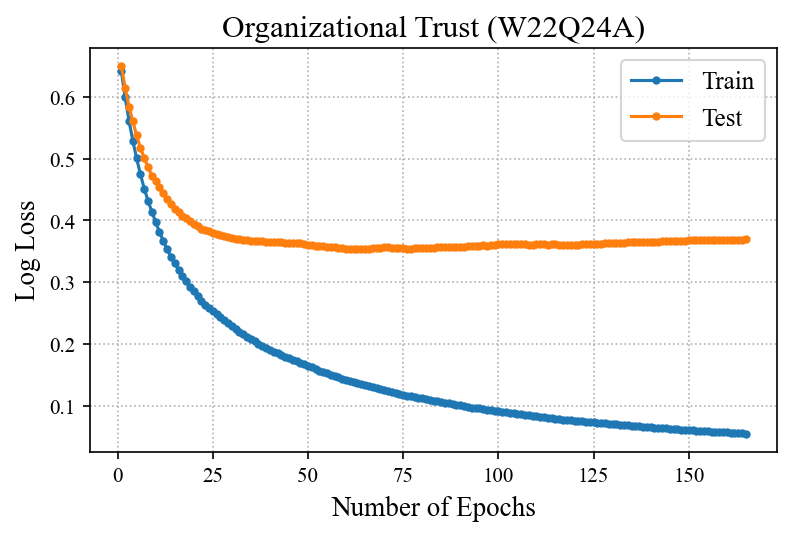

In [82]:
Y = ['W22Q24A', 'W22Q24B', 'W22Q24C', 'W22Q24D', 'W22Q24E', 'W22Q24F']

for i in range(1):  
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    X, y = equal_distirubution(X, Y, i)
    y=y-1
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Organizational Trust (W22Q24A)')

In [57]:
#Multi Class - 5
Y = ['W22Q24A', 'W22Q24B', 'W22Q24C', 'W22Q24D', 'W22Q24E', 'W22Q24F']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    print("RF: ")
    model, x_tr, _, _ = RF(X, y)
    print("XGBoost: ")
    model, x_tr, _, _ = XGBoost(X, y)
    print("LGBM: ")
    model, x_tr, _, _ = LightGBM(X, y)
    print("CatBoost: ")
    model, x_tr, _, _ = CatBoost(X, y)
    
    #RF_grid_search(X, y)
    #Catboost_grid_search(X,y)
    #model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    #feature_imp1(model, x_tr, top_k=10)


 W22Q24A 

W22Q24A
2    3639
1    2549
Name: count, dtype: int64
W22Q24A
2    2549
1    2549
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8774509803921569
XGBoost: 
	Accuracy ========>  0.8696078431372549
LGBM: 
	Accuracy ========>  0.8549019607843137
CatBoost: 
	Accuracy ========>  0.8578431372549019

 W22Q24B 

W22Q24B
2    4227
1    1968
Name: count, dtype: int64
W22Q24B
2    1968
1    1968
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8642131979695431
XGBoost: 
	Accuracy ========>  0.8604060913705583
LGBM: 
	Accuracy ========>  0.8565989847715736
CatBoost: 
	Accuracy ========>  0.8439086294416244

 W22Q24C 

W22Q24C
2    3930
1    1940
Name: count, dtype: int64
W22Q24C
2    1940
1    1940
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8569587628865979
XGBoost: 
	Accuracy ========>  0.8518041237113402
LGBM: 
	Accuracy ========>  0.8402061855670103
CatBoost: 
	Accuracy ========>  0.8182989690721649

 W22Q24D 

W22Q24D
2    4657
1    1313
Name: count, dtype: i


 W22Q24A 

W22Q24A
2    3639
1    2549
Name: count, dtype: int64
W22Q24A
2    2549
1    2549
Name: count, dtype: int64
	Accuracy ========>  0.861764705882353
Index(['W22Q25J', 'W22Q25E', 'W22Q05A', 'W22Q22C', 'W22Q13', 'W22Q23A',
       'W22Q23C', 'W22Q25F', 'W22Q25B', 'W22Q062B'],
      dtype='object')


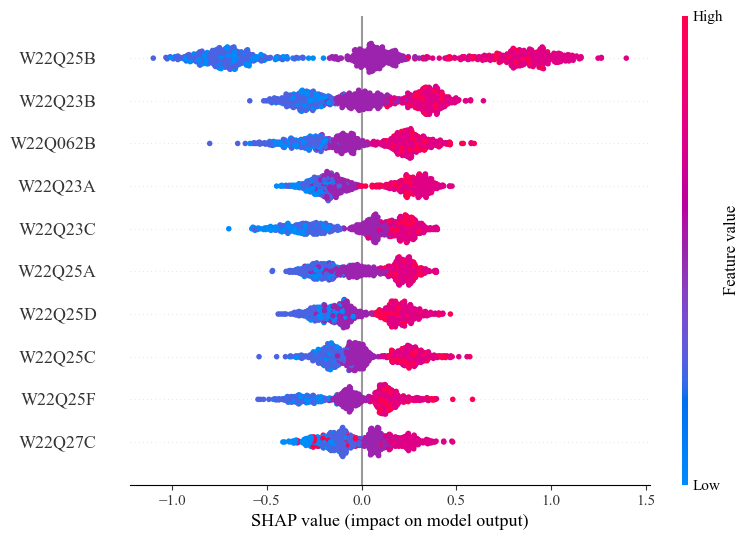


 W22Q24B 

W22Q24B
2    4227
1    1968
Name: count, dtype: int64
W22Q24B
2    1968
1    1968
Name: count, dtype: int64
	Accuracy ========>  0.850253807106599
Index(['W22Q081C', 'W22Q10C', 'W22Q17', 'W22DQ02A', 'W22Q15B2', 'W22Q22F',
       'W22Q19', 'W22Q081B', 'W22Q25I', 'W22Q25D'],
      dtype='object')


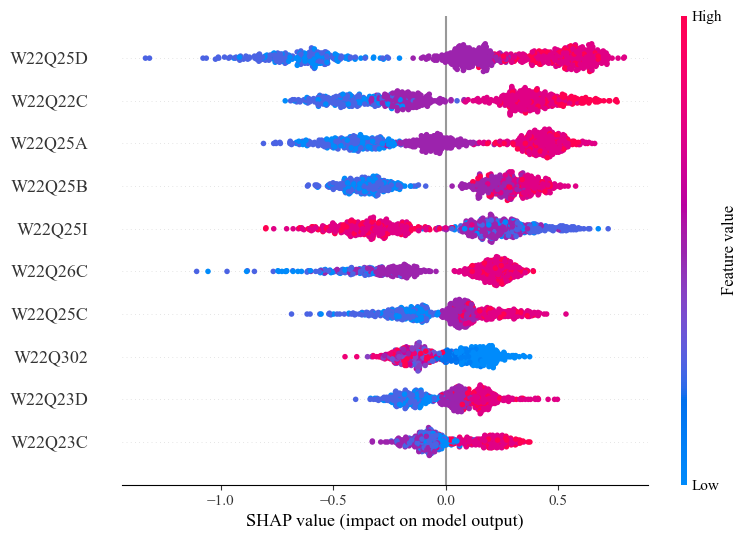


 W22Q24C 

W22Q24C
2    3930
1    1940
Name: count, dtype: int64
W22Q24C
2    1940
1    1940
Name: count, dtype: int64
	Accuracy ========>  0.8724226804123711
Index(['W22Q062A', 'W22Q31A', 'W22Q22A', 'W22Q25B', 'W22Q23A', 'W22Q082A',
       'W22Q22F', 'W22Q23B', 'W22Q25E', 'W22Q25D'],
      dtype='object')


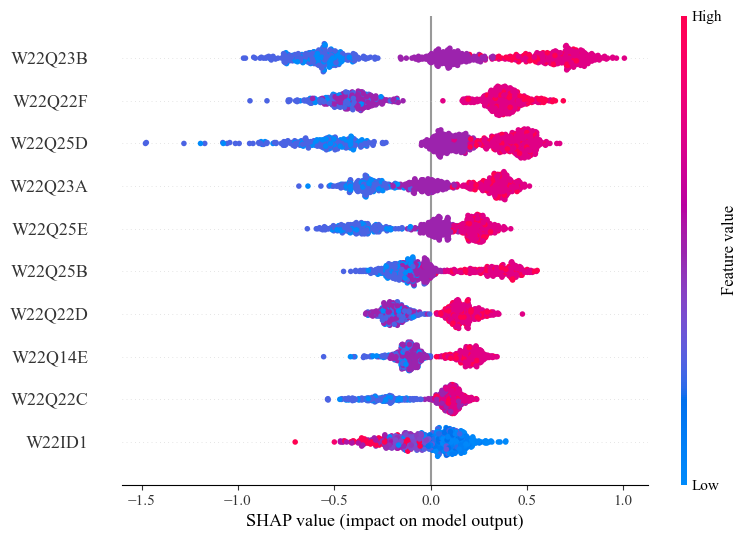


 W22Q24D 

W22Q24D
2    4657
1    1313
Name: count, dtype: int64
W22Q24D
2    1313
1    1313
Name: count, dtype: int64
	Accuracy ========>  0.8859315589353612
Index(['W22DQ01', 'W22Q25F', 'W22Q26A', 'W22SCALE', 'W22Q15C2', 'W22Q22D',
       'W22Q23A', 'W22Q25E', 'W22Q25D', 'W22Q26C'],
      dtype='object')


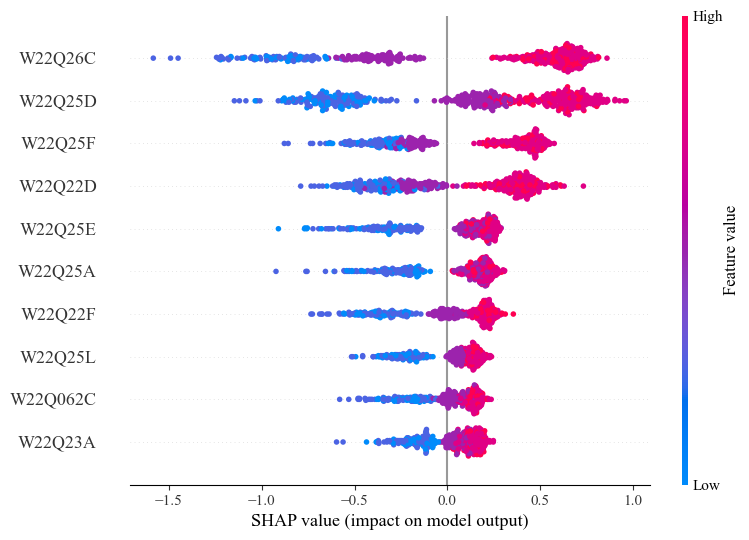


 W22Q24E 

W22Q24E
2    3354
1    2526
Name: count, dtype: int64
W22Q24E
1    2526
2    2526
Name: count, dtype: int64
	Accuracy ========>  0.897131552917903
Index(['W22DQ02A', 'W22Q23A', 'W22Q09F', 'W22Q062C', 'W22Q25L', 'W22Q27E',
       'W22Q31A', 'W22Q23B', 'W22Q26B', 'W22Q25B'],
      dtype='object')


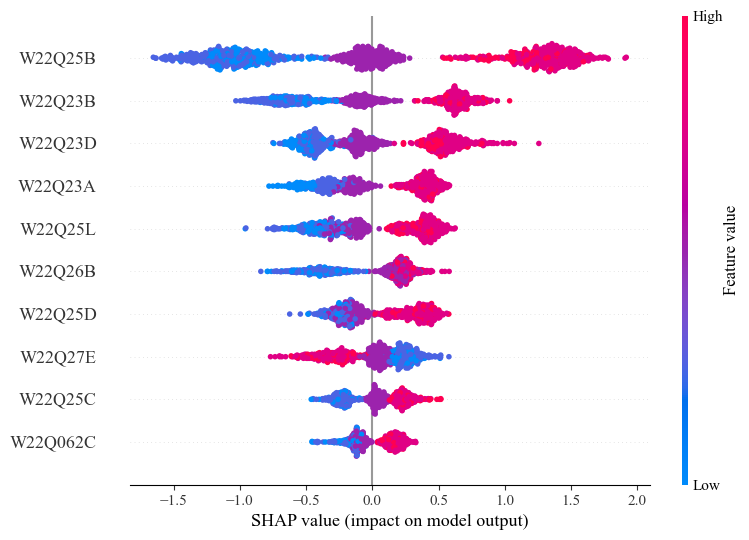


 W22Q24F 

W22Q24F
2    3785
1    2045
Name: count, dtype: int64
W22Q24F
2    2045
1    2045
Name: count, dtype: int64
	Accuracy ========>  0.9083129584352079
Index(['W22Q25C', 'W22Q082D', 'W22Q25D', 'W22Q23A', 'W22Q25E', 'W22Q23C',
       'W22Q081D', 'W22Q27D', 'W22Q23B', 'W22Q25B'],
      dtype='object')


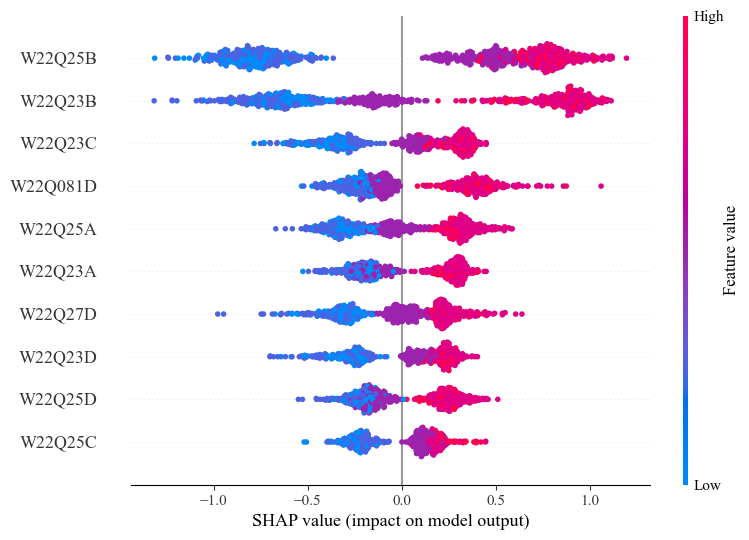

In [40]:
import shap

Y = ['W22Q24A', 'W22Q24B', 'W22Q24C', 'W22Q24D', 'W22Q24E', 'W22Q24F']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)

In [ ]:
#sv = explainer(X)
#shap.plots.waterfall(sv[0])

In [41]:
FI = [['W22Q25B', 'W22Q23B', 'W21Q23C', 'W22Q25A', 'W22Q062B', 'W22Q25D', 'W22Q26B', 'W22Q25C', 'W22Q23A', 'W22Q22A'], 
      ['W22Q25D', 'W22Q22C', 'W22Q25I', 'W22Q25B', 'W22Q25C', 'W22Q25A', 'W22Q25F', 'W22Q23B', 'W22Q23C', 'W22Q22F'],
      ['W22Q25D', 'W22Q25F', 'W22Q23D', 'W22Q25B', 'W22Q22D', 'W22Q22F', 'W22Q27D', 'W22Q25A', 'W22Q25K', 'W22Q25C'],
      ['W22Q26C', 'W22Q25F', 'W22Q25D', 'W22Q22D', 'W22Q081C', 'W22Q25E', 'W22Q23A', 'W22Q082D', 'W22Q25L', 'W22Q25A'],
      ['W22Q25B', 'W22Q23D', 'W22Q23A', 'W22Q23B', 'W22Q25L', 'W22Q25D', 'W22Q27E', 'W22Q26B', 'W22Q261', 'W22Q01A'],
      ['W22Q25B', 'W22Q23B', 'W22Q081D', 'W22Q27D', 'W22Q23D', 'W22Q25A', 'W22Q25D', 'W22Q23C', 'W22Q27E', 'W22Q23A'],
     ]

m2 = ['W22Q23A', 'W22Q25K', 'W22Q23B', 'W22Q23C', 'W22Q261', 'W22Q26C', 'W22Q23D', 'W22Q22D', 'W22Q25D', 'W22Q25B', 'W22Q25B', 
 'W22Q25D', 'W22Q23B', 'W22Q23D', 'W22Q25A', 'W22Q23C', 'W22Q26C', 'W22Q25L', 'W22Q26I', 'W22Q27D']

In [42]:
from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp)).flatten()
arr_1d = arr_1d.tolist() + m2

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: W22Q25D Frequency: 12
Element: W22Q25B Frequency: 11
Element: W22Q23A Frequency: 10
Element: W22Q23B Frequency: 9
Element: W22Q25A Frequency: 6


# 6. 직무만족 (Job Satisfaction)

(1)현재 하고 있는 일의 내용에 만족한다

(2)현재 받고 있는 임금에 만족한다

(3)현재 직장의 인간관계에 만족한다

하고 있는 일에 대한 전반적 만족도

W22Q26A
2    5277
1    1180
Name: count, dtype: int64
W22Q26A
2    1180
1    1180
Name: count, dtype: int64


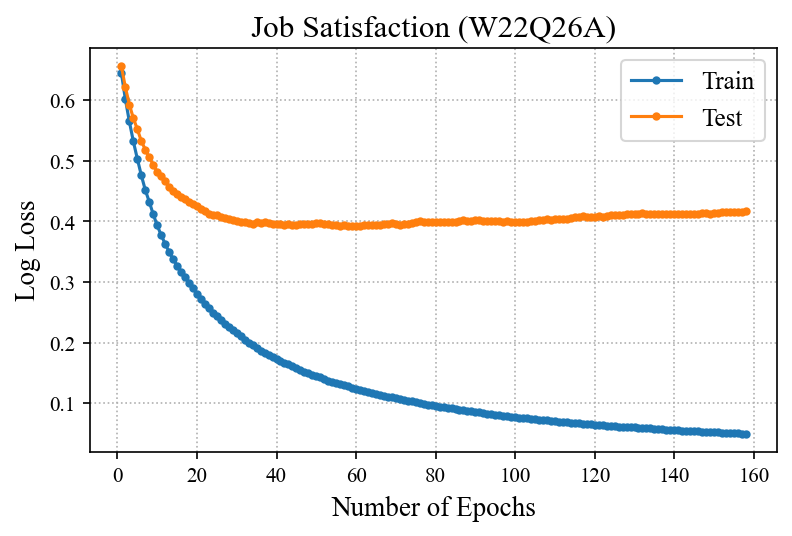

In [83]:
Y = ['W22Q26A', 'W22Q26B', 'W22Q26C', 'W22Q261']

for i in range(1):  
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    X, y = equal_distirubution(X, Y, i)
    y=y-1
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Job Satisfaction (W22Q26A)')

In [59]:
Y = ['W22Q26A', 'W22Q26B', 'W22Q26C', 'W22Q261']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    print("RF: ")
    model, x_tr, _, _ = RF(X, y)
    print("XGBoost: ")
    model, x_tr, _, _ = XGBoost(X, y)
    print("LGBM: ")
    model, x_tr, _, _ = LightGBM(X, y)
    print("CatBoost: ")
    model, x_tr, _, _ = CatBoost(X, y)
    #RF_grid_search(X, y)
    #Catboost_grid_search(X, y)
    #model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    #feature_imp1(model, x_tr, top_k=10)


 W22Q26A 

W22Q26A
2    5277
1    1180
Name: count, dtype: int64
W22Q26A
2    1180
1    1180
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8389830508474576
XGBoost: 
	Accuracy ========>  0.8220338983050848
LGBM: 
	Accuracy ========>  0.8241525423728814
CatBoost: 
	Accuracy ========>  0.8072033898305084

 W22Q26B 

W22Q26B
2    3441
1    2659
Name: count, dtype: int64
W22Q26B
1    2659
2    2659
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8656015037593985
XGBoost: 
	Accuracy ========>  0.8609022556390977
LGBM: 
	Accuracy ========>  0.8609022556390977
CatBoost: 
	Accuracy ========>  0.8477443609022557

 W22Q26C 

W22Q26C
2    5686
1    1016
Name: count, dtype: int64
W22Q26C
2    1016
1    1016
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8574938574938575
XGBoost: 
	Accuracy ========>  0.8501228501228502
LGBM: 
	Accuracy ========>  0.8353808353808354
CatBoost: 
	Accuracy ========>  0.828009828009828

 W22Q261 

W22Q261
2    4323
1    1014
Name: count, dtype: in


 W22Q26A 

W22Q26A
2    5277
1    1180
Name: count, dtype: int64
W22Q26A
2    1180
1    1180
Name: count, dtype: int64
	Accuracy ========>  0.8559322033898306
Index(['W22Q14E', 'W22Q27F', 'W22Q22C', 'W22Q14A', 'W22Q22D', 'W22Q15B2',
       'W22Q24F', 'W22Q24D', 'W22Q22F', 'W22Q27D'],
      dtype='object')


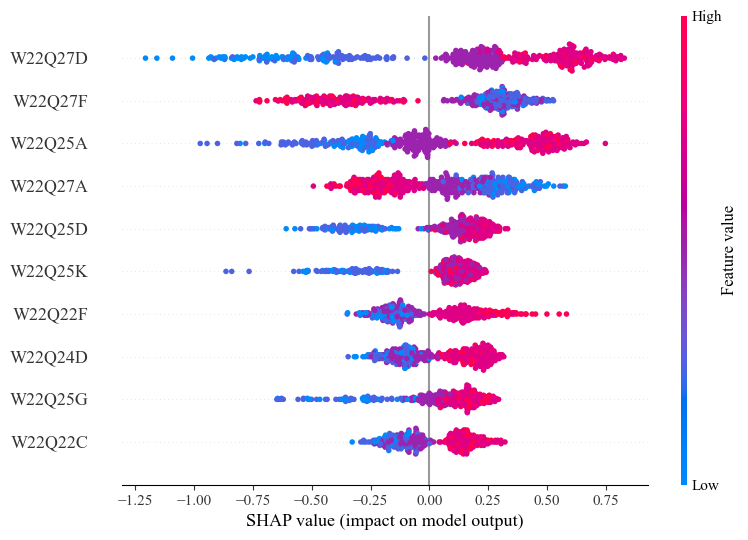


 W22Q26B 

W22Q26B
2    3441
1    2659
Name: count, dtype: int64
W22Q26B
1    2659
2    2659
Name: count, dtype: int64
	Accuracy ========>  0.8289473684210527
Index(['W22Q23D', 'W22Q25I', 'W22Q25L', 'W22Q27D', 'W22Q27F', 'W22Q27C',
       'W22Q27A', 'W22Q31A', 'W22Q27E', 'W22Q24E'],
      dtype='object')


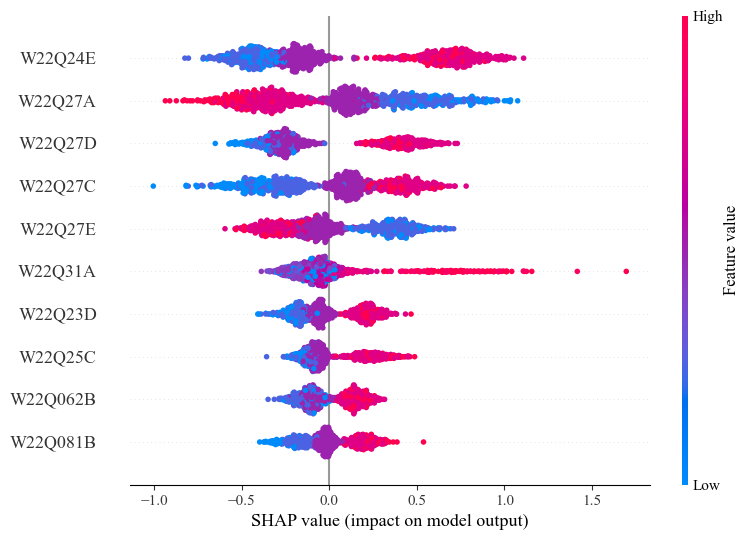


 W22Q26C 

W22Q26C
2    5686
1    1016
Name: count, dtype: int64
W22Q26C
2    1016
1    1016
Name: count, dtype: int64
	Accuracy ========>  0.8771498771498771
Index(['W22Q22D', 'W22Q14D', 'W22Q25E', 'W22Q25K', 'W22Q27F', 'W22Q13',
       'W22Q25F', 'W22Q25D', 'W22Q22F', 'W22Q24D'],
      dtype='object')


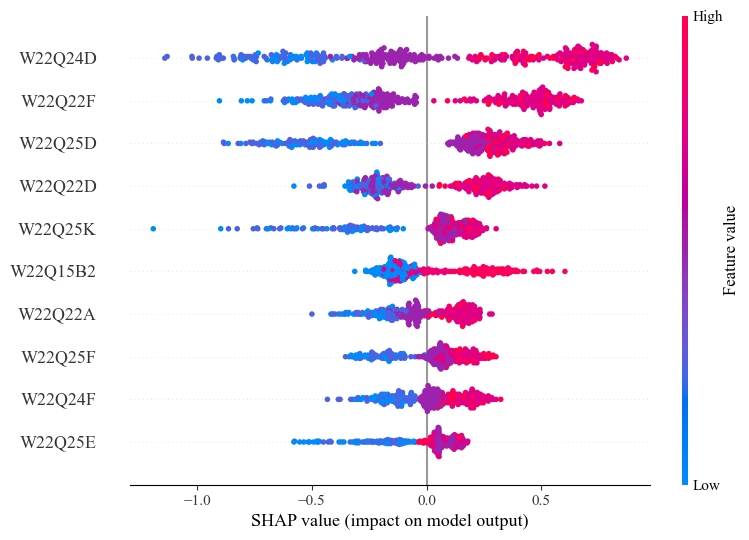


 W22Q261 

W22Q261
2    4323
1    1014
Name: count, dtype: int64
W22Q261
1    1014
2    1014
Name: count, dtype: int64
	Accuracy ========>  0.8990147783251231
Index(['W22Q23B', 'W22Q11A2', 'W22Q24B', 'W22Q25K', 'W22Q27E', 'W22Q22B',
       'W22Q27B', 'W22Q25F', 'W22Q27D', 'W22Q27F'],
      dtype='object')


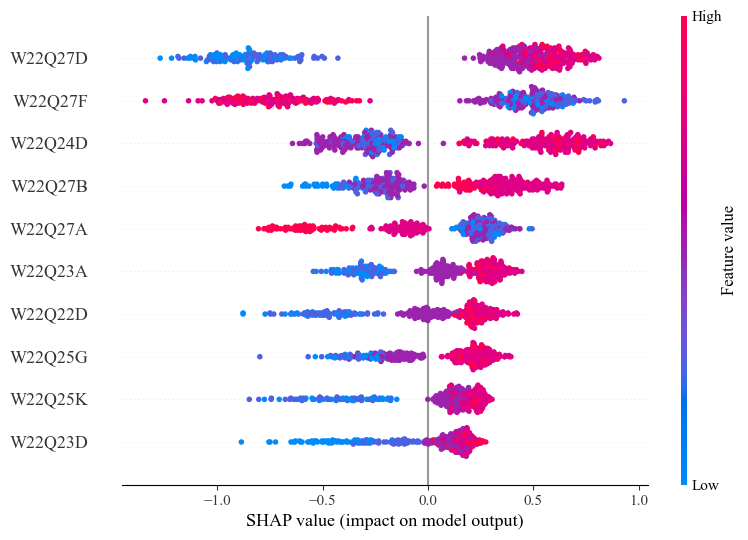

In [45]:
import shap

Y = ['W22Q26A', 'W22Q26B', 'W22Q26C', 'W22Q261']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)

In [46]:
FI = [['W22Q27F', 'w22Q27D', 'w22Q24F', 'w22Q24D', 'w22Q22C', 'w22Q27A', 'w22Q24E', 'w22Q23B', 'w22Q25D', 'w22Q25G'], 
     ['W22Q24E', 'w22Q27A', 'w22Q27D', 'w22Q27C', 'w22Q23A', 'w22Q27F', 'w22Q27E', 'w22QID1', 'w22QDQ01', 'w22Q25B'], 
     ['W22Q24D', 'w22Q27D', 'w22Q22D', 'w22Q25D', 'w22Q27F', 'w22Q15B1', 'w22Q22A', 'w22Q25E', 'w22Q15C1', 'w22Q02A'], 
     ['W22Q24D', 'w22Q27D', 'w22Q27F', 'w22Q27A', 'w22Q23A', 'w22Q24F', 'w22Q27E', 'w22Q27B', 'w22Q25F', 'w22Q24E']]

m2 = ['w22Q27F', 'w22Q09D', 'w22Q22D', 'w22DQ02A', 'w22ID1', 'w22Q27B',
       'w22Q27D', 'w22Q24D', 'w22Q25E', 'w22Q22F', 'w22Q27D', 'w22Q24F',
       'w22Q24D', 'w22Q25D', 'w22Q27F', 'w22Q24E', 'w22Q27A', 'w22Q23A',
       'w22Q22D', 'w22Q25B']

In [47]:
from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp)).flatten()
arr_1d = arr_1d.tolist() + m2

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: w22Q27D Frequency: 6
Element: W22Q27F Frequency: 5
Element: w22Q27F Frequency: 5
Element: w22Q27A Frequency: 4
Element: W22Q24D Frequency: 4


# 7. 조직몰입 

(1) 나는 조금이라도 좋은 조건을 제시하는 회사가 있으면 옮길 것을 고려해 보고 있다

(2) 나는 이 회사의 문제를 내 문제처럼 느낀다

(3) 만약 내가 이 회사를 떠나기로 결정한다면 내 인생의 너무 많은 것을 잃게 될 것이다

(4) 이 회사는 내가 충성할 만한 가치가 있다

W22Q27A
2    3766
1    2513
Name: count, dtype: int64
W22Q27A
2    2513
1    2513
Name: count, dtype: int64


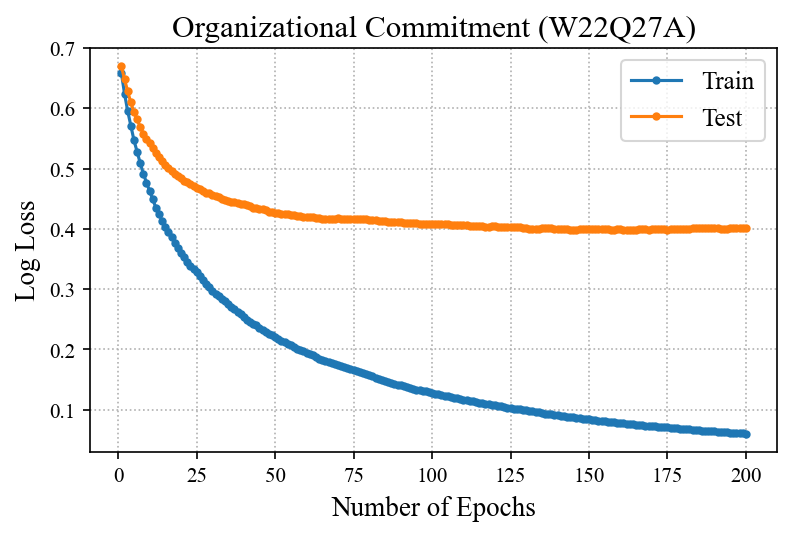

In [84]:
Y = ['W22Q27A', 'W22Q27B', 'W22Q27C', 'W22Q27D']

for i in range(1):  
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    X, y = equal_distirubution(X, Y, i)
    y=y-1
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Organizational Commitment (W22Q27A)')

In [60]:
Y = ['W22Q27A', 'W22Q27B', 'W22Q27C', 'W22Q27D']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    print("RF: ")
    model, x_tr, _, _ = RF(X, y)
    print("XGBoost: ")
    model, x_tr, _, _ = XGBoost(X, y)
    print("LGBM: ")
    model, x_tr, _, _ = LightGBM(X, y)
    print("CatBoost: ")
    model, x_tr, _, _ = CatBoost(X, y)
    #RF_grid_search(X, y)
    #Catboost_grid_search(X, y)
    #model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    #feature_imp1(model, x_tr, top_k=10)


 W22Q27A 

W22Q27A
2    3766
1    2513
Name: count, dtype: int64
W22Q27A
2    2513
1    2513
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8290258449304175
XGBoost: 
	Accuracy ========>  0.81610337972167
LGBM: 
	Accuracy ========>  0.8151093439363817
CatBoost: 
	Accuracy ========>  0.7922465208747514

 W22Q27B 

W22Q27B
2    4514
1    1615
Name: count, dtype: int64
W22Q27B
2    1615
1    1615
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8095975232198143
XGBoost: 
	Accuracy ========>  0.7925696594427245
LGBM: 
	Accuracy ========>  0.7879256965944272
CatBoost: 
	Accuracy ========>  0.7879256965944272

 W22Q27C 

W22Q27C
1    3561
2    2521
Name: count, dtype: int64
W22Q27C
2    2521
1    2521
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8166501486620417
XGBoost: 
	Accuracy ========>  0.8136769078295342
LGBM: 
	Accuracy ========>  0.8057482656095144
CatBoost: 
	Accuracy ========>  0.7898909811694748

 W22Q27D 

W22Q27D
2    3435
1    1959
Name: count, dtype: int


 W22Q27A 

W22Q27A
2    3766
1    2513
Name: count, dtype: int64
W22Q27A
2    2513
1    2513
Name: count, dtype: int64
	Accuracy ========>  0.8210735586481114
Index(['W22Q15E2', 'W22Q26B', 'W22Q05A', 'W22Q09E', 'W22Q25J', 'W22ID1',
       'W22Q27F', 'W22Q261', 'W22DQ02A', 'W22Q27E'],
      dtype='object')


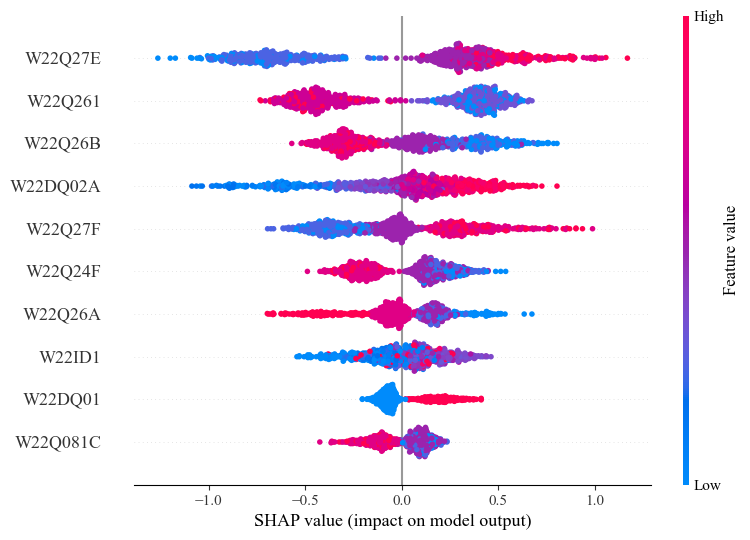


 W22Q27B 

W22Q27B
2    4514
1    1615
Name: count, dtype: int64
W22Q27B
2    1615
1    1615
Name: count, dtype: int64
	Accuracy ========>  0.7786377708978328
Index(['W22Q24B', 'W22Q15A2', 'W22Q061D', 'W22Q22B', 'W22DQ02A', 'W22DQ03',
       'W22Q24C', 'W22Q261', 'W22Q26C', 'W22Q27G'],
      dtype='object')


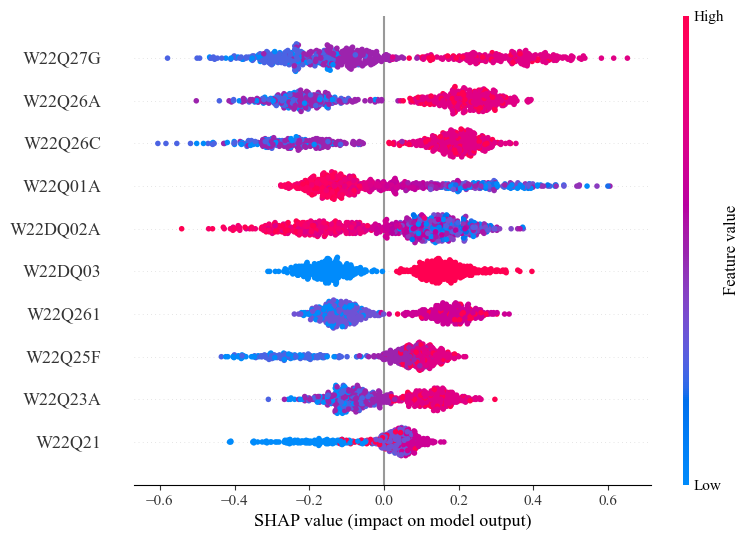


 W22Q27C 

W22Q27C
1    3561
2    2521
Name: count, dtype: int64
W22Q27C
2    2521
1    2521
Name: count, dtype: int64
	Accuracy ========>  0.8107036669970268
Index(['W22Q12B', 'W22DQ01', 'W22Q01A', 'W22Q25B', 'W22Q22A', 'W22Q18B',
       'W22ID1', 'W22Q26A', 'W22Q27G', 'W22Q27E'],
      dtype='object')


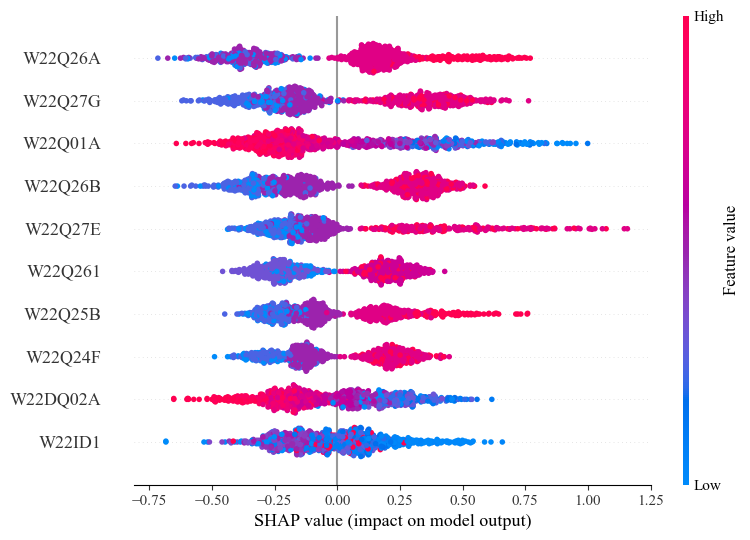


 W22Q27D 

W22Q27D
2    3435
1    1959
Name: count, dtype: int64
W22Q27D
2    1959
1    1959
Name: count, dtype: int64
	Accuracy ========>  0.8801020408163265
Index(['W22Q24A', 'W22Q26A', 'W22Q083A', 'W22Q15A1', 'W22Q25B', 'W22Q25F',
       'W22Q261', 'W22Q26C', 'W22Q25D', 'W22Q24F'],
      dtype='object')


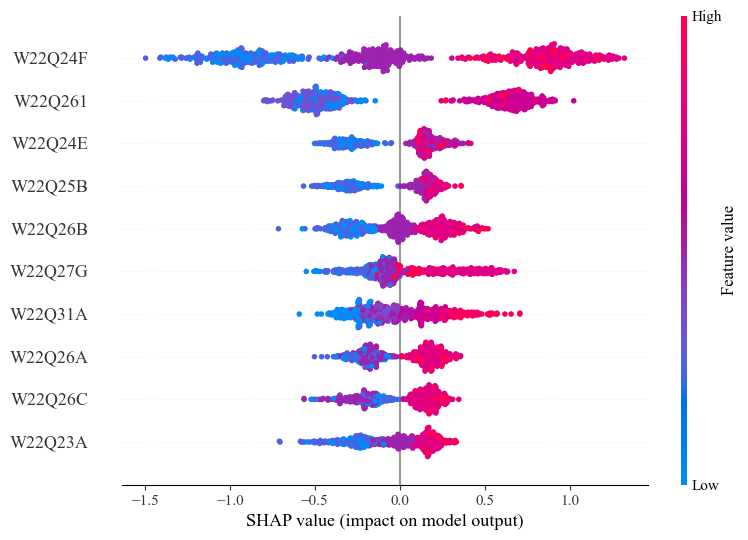

In [50]:
import shap

Y = ['W22Q27A', 'W22Q27B', 'W22Q27C', 'W22Q27D']
perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)

In [51]:
FI = [['w22Q27E', 'w22Q26B', 'w22Q27F', 'w22DQ02A', 'w22Q261', 'w22Q26A', 'w22Q01A', 'w22Q25I', 'w22Q24F', 'w22Q03B'],
      ['w22Q26A', 'w22Q27G', 'w22Q24F', 'w22DQ02A', 'w22Q25F', 'w22Q261', 'w22Q03B', 'w22DQ03', 'w22Q26C', 'w22Q24A'],
      ['w22Q27G', 'w22Q01A', 'w22Q26B', 'w22Q261', 'w22Q27E', 'w22Q24F', 'w22DQ02A', 'w22Q23C', 'w22Q24A', 'w22ID1'],
      ['w22Q24F', 'w22Q261', 'w22Q23B', 'w22Q26A', 'w22Q27G', 'w22Q26B', 'w22Q25D', 'w22Q25F', 'w22Q25C', 'w22Q25G'],
     ]
m2 = ['w22Q081C', 'w22Q12C', 'w22Q02A', 'w22Q07', 'w22Q27G', 'w22DQ03',
       'w22Q261', 'w22DQ02A', 'w22Q27F', 'w22Q27E', 'w22Q261', 'w22Q24F',
       'w22Q26A', 'w22Q27E', 'w22DQ02A', 'w22Q26B', 'w22Q27G', 'w22Q01A','w22Q27F', 'w22Q24A']


from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp)).flatten()
arr_1d = arr_1d.tolist() + m2

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: w22Q261 Frequency: 6
Element: w22DQ02A Frequency: 5
Element: w22Q24F Frequency: 5
Element: w22Q27G Frequency: 5
Element: w22Q27E Frequency: 4


# 8. 번아웃 

(6) 나는 현재 업무로 인해 무력감이나 피곤함을 느낄 때가 많아졌다

In [ ]:
Y = ['W22Q27F']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Burnout (W22Q27F)')


 W22Q27F 

W22Q27F
2    3149
1    2669
Name: count, dtype: int64
W22Q27F
1    2669
2    2669
Name: count, dtype: int64
	Accuracy ========>  0.8295880149812734


In [53]:
FI = ['w22Q27G', 'w22Q27E', 'w22Q26A', 'w22Q27A', 'w22Q261', 'w22Q25I', 'w22Q302', 'w22Q01A', 'w22Q21', 'w22QID1']

from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp[0])).flatten()

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: w22Q27GW22DQ04 Frequency: 1
Element: w22Q27EW22Q14B Frequency: 1
Element: w22Q26AW22Q23B Frequency: 1
Element: w22Q27AW22Q31A Frequency: 1
Element: w22Q261W22Q09B Frequency: 1


In [61]:
Y = ['W22Q27F']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    print("RF: ")
    model, x_tr, _, _ = RF(X, y)
    print("XGBoost: ")
    model, x_tr, _, _ = XGBoost(X, y)
    print("LGBM: ")
    model, x_tr, _, _ = LightGBM(X, y)
    print("CatBoost: ")
    model, x_tr, _, _ = CatBoost(X, y)

    #RF_grid_search(X, y)
    #Catboost_grid_search(X,y)
    #model, x_tr, x_tst, y_tst = XGBoost(X, y, num_boost_round = 300)
    feature_imp1(model, x_tr, top_k=15)


 W22Q27F 

W22Q27F
2    3149
1    2669
Name: count, dtype: int64
W22Q27F
1    2669
2    2669
Name: count, dtype: int64
RF: 
	Accuracy ========>  0.8258426966292135
XGBoost: 
	Accuracy ========>  0.8277153558052435
LGBM: 
	Accuracy ========>  0.8061797752808989
CatBoost: 
	Accuracy ========>  0.802434456928839


In [81]:
np.mean([87.54, 85.74, 87.39, 88.86, 94.25, 93.03, 84.43, 88.14, 83.4, 86.98, 81.74, 79.02, 84.19, 90.27, 86.91])
np.std([87.54, 85.74, 87.39, 88.86, 94.25, 93.03, 84.43, 88.14, 83.4, 86.98, 81.74, 79.02, 84.19, 90.27, 86.91])

3.869362508504757

In [80]:
np.mean([87.53, 86.42, 85.7, 87.45, 90.41, 91.2, 83.89, 86.56, 85.75, 84.98, 82.9, 80.96, 81.66, 90.56, 82.58])
np.std([87.53, 86.42, 85.7, 87.45, 90.41, 91.2, 83.89, 86.56, 85.75, 84.98, 82.9, 80.96, 81.66, 90.56, 82.58])

3.090453400752425

In [79]:
np.mean([87.33, 86.9, 88.54, 90.36, 94.79, 92.32, 85.03, 88.08, 82.18, 90.48, 81.33, 80.02, 83.65, 89.77, 86.91])
np.std([87.33, 86.9, 88.54, 90.36, 94.79, 92.32, 85.03, 88.08, 82.18, 90.48, 81.33, 80.02, 83.65, 89.77, 86.91])

4.0203407263011375

In [78]:
np.mean([86.96, 86.04, 85.18, 87.61, 89.12, 91.32, 82.03, 86.09, 85.01, 84.48, 81.61, 79.25, 81.36, 87.88, 82.77])
np.std([86.96, 86.04, 85.18, 87.61, 89.12, 91.32, 82.03, 86.09, 85.01, 84.48, 81.61, 79.25, 81.36, 87.88, 82.77])

3.1605965681602997

In [77]:
np.mean([87.23, 86.03, 88.11, 89.1, 93.7, 92.88, 85.63, 87.18, 85.02, 89.52, 81.42, 78.62, 83.98, 89.07, 86.80])
np.std([87.23, 86.03, 88.11, 89.1, 93.7, 92.88, 85.63, 87.18, 85.02, 89.52, 81.42, 78.62, 83.98, 89.07, 86.80])

3.7687565883487637

In [76]:
np.mean([85.49, 85.66, 84.02, 87.45, 89.02, 91.32, 82.41, 86.09, 83.54, 82.76, 81.51, 78.79, 80.57, 89.03, 80.61])
np.std([85.49, 85.66, 84.02, 87.45, 89.02, 91.32, 82.41, 86.09, 83.54, 82.76, 81.51, 78.79, 80.57, 89.03, 80.61])


3.479936525602473

In [75]:
np.mean([87.02, 87.05, 87.39, 87.62, 93.49, 93.46, 85.33, 85.91, 84.62, 88.57, 79.72, 77.60, 83.06, 90.57, 85.41])
np.std([87.02, 87.05, 87.39, 87.62, 93.49, 93.46, 85.33, 85.91, 84.62, 88.57, 79.72, 77.60, 83.06, 90.57, 85.41])

4.196757266694792

In [74]:
np.mean([85.78, 84.39, 81.82, 85.74, 89.22, 90.59, 80.72, 84.77, 82.8, 83, 79.22, 78.79, 78.98, 88.64, 80.24])
np.std([85.78, 84.39, 81.82, 85.74, 89.22, 90.59, 80.72, 84.77, 82.8, 83, 79.22, 78.79, 78.98, 88.64, 80.24])

3.692837511844908

# Feature importance랑 Permutation importance는 유사함 (sorting)

# SMOTE -> data augmentation based on synthetic dataset

justification: 심하게 skewed 된 학습데이터만 증강 기법을 써서 올림 => test 데이터 자체는 그대로 유지

Overfitting 이 보이는 시점이 있음 => 실제로 어느정도는 도움이 된다는 뜻

In [ ]:
from xgboost import XGBClassifier, plot_importance
scaler = MinMaxScaler()
from imblearn.over_sampling import SMOTE

X = df_no_nan.drop(columns=[Y[target_idx]])
y = df_no_nan[Y[target_idx]] 
X_normalized = scaler.fit_transform(X)
df = pd.DataFrame(X_normalized, columns=X.columns)

print(y.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)

print(y_resampled.value_counts())

In [ ]:
y_resampled = y_resampled - 1

X_train, X_test, y_train, y_test = train_test_split(balanced_df, y_resampled, test_size=0.2, random_state=42)

num_boost_round = 300  
model = XGBClassifier(n_estimators=num_boost_round)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)